In [2]:
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords

from IPython.display import display, HTML

sns.set(style='darkgrid')

In [3]:
def get_bold(x):
    open_tag_bold = "\033[1m"
    close_tag_bold = "\033[0m"
    return open_tag_bold + str(x) + close_tag_bold


## Remove duplicate entries
def remove_duplicate(duplicate): 
    duplicate.sort()
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

## Review words
def review_words(raw_review):
    
    if not isinstance(raw_review, str):
        return str(0)
    
    #1. removing only what is needed
    letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                       # The pattern to replace it with
                      raw_review)       # The text to search

    # 2. Tokenizing individual words
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    #5. remove duplicates
    meaningful_words = remove_duplicate(meaningful_words)
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(",".join(meaningful_words))

#clean words for an entire column/series
def get_clean_words(data):
    clean_words = []
    
    for w in data:
        clean_words.append(review_words(w))
    
    return clean_words

#combine full row into a single row
def get_full_row(data, features):
    data["full_row"] = ""
    for col in features:
        data["full_row"] = data["full_row"] + "," + data[col].astype(str)
    

#simple model,fit,evaluate
def simple_model_fit_evaluate(X, y, cvec, estimator, scores):
    
    # Create train_test_split.
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    shuffle = True,
                                                    stratify = y)
    
    
    train_data_features = cvec.fit_transform(X_train)
    test_data_features = cvec.transform(X_test)
    
    
    # Fit model to training data.
    lr.fit(train_data_features, y_train)
    
    #confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, lr.predict(test_data_features)).ravel()
    
    ##calulating accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    #calculating Misclassification Rate
    mis_calcuations = 1 - accuracy
    
    #calculating sensitivity
    sensitivity = tp / (tp + fn)

    #calculating specificity
    specificity = tn / (tn + fp)

    #calculating precision
    precision = tp / (tp + fp)
    
    #to predict roc_auc_score
    pred_proba = [i[1] for i in lr.predict_proba(test_data_features)]

    pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

    scores["Train Scores"].append(round(lr.score(train_data_features, y_train),2))
    scores["Test Scores"].append(round(lr.score(test_data_features, y_test),2))
    scores["Accuracy"].append(round(accuracy_score(y_test, lr.predict(test_data_features)),2))
    scores["Mis Calculations"].append(round(mis_calcuations,2))
    scores["Sensitivity"].append(round(sensitivity,2))
    scores["Specificity"].append(round(specificity,2))
    scores["Precision"].append(round(precision,2))
    scores["ROC AUC"].append(round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),2))
    
    if lr.score(train_data_features, y_train) > lr.score(test_data_features, y_test):
        scores["Fit Type"].append("Overfit")
    else:
        scores["Fit Type"].append("Underfit")
    

#combine two subreddits
def combine(subreddit1, subreddit2):
    
    all_data_df = pd.concat((subreddit1, subreddit2), axis=0)
    sub1 = subreddit1["subreddit"].unique()[0]
    sub2 = subreddit2["subreddit"].unique()[0]
    
    clean_features=["link_flair_text", "title", "selftext"]
    all_data_df["y"] = all_data_df["subreddit"].map({sub1: 0, sub2: 1})
    for cf in clean_features:
        all_data_df[cf] = get_clean_words(all_data_df[cf])
    
    all_data_df["author"] = all_data_df["author"].str.lower().str.replace("_", " ").str.replace("-", " ")
    all_data_df["domain"] = all_data_df["domain"].astype(str)
    
    return all_data_df

 
def clean_subreddit(subreddit):
    
    clean_features=["link_flair_text", "title", "selftext"]
    for cf in clean_features:
        subreddit[cf] = get_clean_words(subreddit[cf])
    
    subreddit["author"] = subreddit["author"].str.lower().str.replace("_", " ").str.replace("-", " ")
    subreddit["domain"] = subreddit["domain"].astype(str)
    
    return subreddit
    

# display scores 
def display_scores(scores, no_of_posts):
    
    print("\nMetrics for {} posts".format(get_bold(no_of_posts)))
    df = pd.DataFrame(scores)
    df = df.sort_values(by="ROC AUC", ascending=True)
#     display(df)
    display(HTML(df.to_html()))
#     sns.set(style="darkgrid")
    nrows = 1 # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=8, figsize=(18,3)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    col_list = ["ROC AUC", "Accuracy", "Mis Calculations","Sensitivity","Specificity","Precision", "Test Scores","Train Scores"]
    col_colr = ["blue", "slategray", "green", "sienna", "teal", "firebrick", "lightseagreen", "mediumorchid"]
    for i, column in enumerate(col_list): # Gives us an index value to get into all our lists
        sns.scatterplot(df[column], df["Feature Set"],marker="o", size=df[column], legend=False, facecolor=col_colr[i], edgecolor=col_colr[i], ax=ax[i])
        ax[i].set_ylabel("");
        

#Count Vectorizer
cevc = CountVectorizer(analyzer = "word",max_features = 5000) 

# Instantiate logistic regression model.
lr = LogisticRegression(solver= 'liblinear')

feature_sets={"1": ["title"],
              "2": ["title", "selftext"],
              "3": ["title", "selftext", "author"],
              "4": ["title", "selftext", "author", "domain"],
              "5": ["title", "selftext", "author", "domain", "link_flair_text"],
              "6": ["title", "selftext", "author", "domain", "author_fullname"],
              "7": ["author", "author_flair_text", "author_fullname", "domain", "link_flair_text", "title",
                           "selftext", "num_comments", "created_utc"]
             }

def map_features(x):
    return ",".join(feature_sets[x])

def display_top_words(evolution_submission_df, creation_submission_df, all_data_df):
    ##cleaing each subreddit separetly and reading the top 50 words
    evolution_top_w = {str(features): {} for features in feature_sets}
    creation_top_w = {str(features): {} for features in feature_sets}
    all_top_w = {str(features): {} for features in feature_sets}
    
    clean_evolution = clean_subreddit(evolution_submission_df)
    clean_creation = clean_subreddit(creation_submission_df)
    
    for features in feature_sets:
        get_full_row(clean_evolution, feature_sets[features])
        get_full_row(clean_creation, feature_sets[features])
        get_full_row(all_data_df, feature_sets[features])
        get_top_n_words(clean_evolution["full_row"], evolution_top_w, features, n=50)
        get_top_n_words(clean_creation["full_row"], creation_top_w, features, n=50)
        get_top_n_words(all_data_df["full_row"], all_top_w, features, n=50)
    
    print("\n{}".format(get_bold("Top words used under r/evolution")))
    evolution_top_w_df = pd.DataFrame(evolution_top_w)
    evolution_top_w_df.dropna(inplace=True)
    display(HTML(evolution_top_w_df.to_html()))
    
    print("\n{}".format(get_bold("Top words used under r/Creation")))
    creation_top_w_df = pd.DataFrame(creation_top_w)
    creation_top_w_df.dropna(inplace=True)
    display(HTML(creation_top_w_df.to_html()))
    
    print("\n{}".format(get_bold("Top words used under r/evolution and r/Creation combined")))
    all_top_w_df = pd.DataFrame(all_top_w)
    all_top_w_df.dropna(inplace=True)
    display(HTML(all_top_w_df.to_html()))


#EDA for each run
def evolution_creation_model_simple(run):
    evolution_submission_df = pd.read_csv("./datasets/evolution_submission_" + run+ ".csv")
    creation_submission_df = pd.read_csv("./datasets/creation_submission_" + run + ".csv")

    
    all_data_df = combine(evolution_submission_df, creation_submission_df)
    
### EDA for authors
    evolution_list_authors = list(evolution_submission_df["author"].unique())
    creation_list_authors = list(creation_submission_df["author"].unique())
    
    evolution_no_authors = len(evolution_list_authors)
    creation_no_authors = len(creation_list_authors)
    print("\n{}".format(get_bold("Number of authors:")))
    print("Most recent {} evolution posts are from {} authors.".format(get_bold(evolution_submission_df.shape[0]),get_bold(evolution_no_authors)))
    print("Most recent {} creation posts are from {} authors.".format(get_bold(creation_submission_df.shape[0]),get_bold(creation_no_authors)))
    print("\n")
    
    ##check which authors are common in both the posts
    common_authors = []
    
    for author in evolution_list_authors:
        if author in creation_list_authors:
            common_authors.append(author)
            
    common_no_authors = len(common_authors)  
            
    print("{}".format(get_bold("Number of common authors:")))
    print("Common authors : {} authors".format(get_bold(common_no_authors)))
    print("\n")
    
##  EDA for top words
    display_top_words(evolution_submission_df, creation_submission_df, all_data_df)

##  model/predict/evaluate
    scores = {"Feature Set":[],
              "Train Scores":[], 
              "Test Scores": [], 
              "Accuracy": [],
              "Mis Calculations": [],
              "Sensitivity": [],
              "Specificity": [], 
              "Precision": [],
              "ROC AUC":[],
              "Fit Type": []}

    for features in feature_sets:
        get_full_row(all_data_df, feature_sets[features])
        scores["Feature Set"].append(features)
        simple_model_fit_evaluate(all_data_df["full_row"], all_data_df["y"], cevc, lr, scores)

            
    display_scores(scores, all_data_df.shape[0])
    


Number of authors:
Most recent 100 evolution posts are from 78 authors.
Most recent 100 creation posts are from 32 authors.


Number of common authors:
Common authors : 0 authors



Top words used under r/evolution


,1,2,3,4,5,6,7
evolution,22.0,39.0,39.0,101.0,101.0,101.0,101.0
human,11.0,19.0,19.0,19.0,19.0,19.0,19.0
species,7.0,20.0,20.0,20.0,20.0,20.0,20.0
humans,7.0,15.0,15.0,15.0,15.0,15.0,15.0
evolutionary,6.0,15.0,15.0,15.0,15.0,15.0,15.0
like,4.0,18.0,18.0,18.0,18.0,18.0,18.0
life,3.0,12.0,12.0,12.0,12.0,12.0,12.0



Top words used under r/Creation


,1,2,3,4,5,6,7
creation,12.0,35.0,35.0,95.0,95.0,95.0,96.0
debate,11.0,23.0,23.0,23.0,23.0,23.0,23.0
evolution,11.0,33.0,33.0,33.0,33.0,33.0,33.0
evidence,6.0,29.0,29.0,29.0,29.0,29.0,29.0
science,5.0,23.0,23.0,23.0,23.0,23.0,37.0
like,5.0,35.0,35.0,35.0,35.0,35.0,35.0



Top words used under r/evolution and r/Creation combined


,1,2,3,4,5,6,7
evolution,33.0,72.0,72.0,134.0,134.0,134.0,134.0
creation,12.0,36.0,36.0,96.0,96.0,96.0,97.0
human,11.0,31.0,31.0,31.0,31.0,31.0,31.0
like,9.0,53.0,53.0,53.0,53.0,53.0,53.0
earth,9.0,28.0,28.0,28.0,28.0,28.0,28.0
life,8.0,31.0,31.0,31.0,31.0,31.0,31.0
evidence,6.0,30.0,30.0,30.0,30.0,30.0,30.0



Metrics for 200 posts


,Feature Set,Train Scores,Test Scores,Accuracy,Mis Calculations,Sensitivity,Specificity,Precision,ROC AUC,Fit Type
0,1,1.00,0.61,0.61,0.39,0.79,0.42,0.58,0.71,Overfit
1,2,0.99,0.74,0.74,0.26,0.73,0.76,0.75,0.84,Overfit
2,3,1.00,0.88,0.88,0.12,0.85,0.91,0.90,0.91,Overfit
3,4,1.00,0.77,0.77,0.23,0.82,0.73,0.75,0.91,Overfit
4,5,1.00,0.82,0.82,0.18,0.82,0.82,0.82,0.92,Overfit
5,6,1.00,0.83,0.83,0.17,0.85,0.82,0.82,0.94,Overfit
6,7,1.00,0.86,0.86,0.14,0.82,0.91,0.90,0.95,Overfit


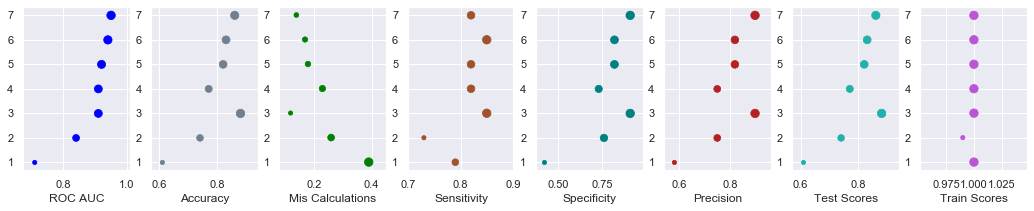

In [4]:
#RUN 1
run = 1
evolution_creation_model_simple(str(run))


Number of authors:
Most recent 1000 evolution posts are from 633 authors.
Most recent 1000 creation posts are from 163 authors.


Number of common authors:
Common authors : 3 authors



Top words used under r/evolution


,1,2,3,4,5,6,7
evolution,281.0,467.0,467.0,1079.0,1079.0,1079.0,1087.0
evolutionary,79.0,166.0,166.0,166.0,166.0,166.0,166.0
human,73.0,144.0,144.0,144.0,144.0,144.0,144.0
humans,73.0,164.0,164.0,164.0,164.0,164.0,164.0
species,63.0,162.0,162.0,162.0,162.0,162.0,162.0
would,36.0,181.0,181.0,181.0,181.0,181.0,181.0
like,35.0,172.0,173.0,173.0,173.0,173.0,173.0
life,31.0,104.0,104.0,104.0,104.0,104.0,104.0
selection,25.0,84.0,84.0,84.0,84.0,84.0,84.0
one,22.0,131.0,132.0,132.0,132.0,132.0,132.0



Top words used under r/Creation


,1,2,3,4,5,6,7
evolution,129.0,287.0,287.0,287.0,287.0,287.0,287.0
creation,64.0,222.0,222.0,698.0,698.0,698.0,708.0
science,53.0,162.0,162.0,162.0,162.0,162.0,197.0
new,52.0,142.0,142.0,142.0,143.0,142.0,143.0
evidence,52.0,159.0,159.0,159.0,159.0,159.0,159.0
years,41.0,142.0,142.0,142.0,142.0,142.0,145.0
life,29.0,135.0,135.0,135.0,135.0,135.0,136.0
would,26.0,231.0,231.0,231.0,231.0,231.0,231.0
time,26.0,148.0,148.0,149.0,149.0,149.0,149.0



Top words used under r/evolution and r/Creation combined


,1,2,3,4,5,6,7
evolution,410.0,754.0,754.0,1366.0,1366.0,1366.0,1374.0
human,101.0,262.0,262.0,262.0,262.0,262.0,262.0
humans,98.0,247.0,247.0,247.0,247.0,247.0,247.0
evolutionary,96.0,260.0,260.0,260.0,260.0,260.0,261.0
species,78.0,226.0,226.0,226.0,226.0,226.0,226.0
creation,68.0,230.0,230.0,706.0,706.0,706.0,716.0
would,62.0,412.0,412.0,412.0,412.0,412.0,412.0
life,60.0,239.0,239.0,239.0,239.0,239.0,240.0
like,57.0,382.0,383.0,383.0,383.0,383.0,383.0
time,40.0,233.0,235.0,236.0,236.0,236.0,236.0



Metrics for 2000 posts


,Feature Set,Train Scores,Test Scores,Accuracy,Mis Calculations,Sensitivity,Specificity,Precision,ROC AUC,Fit Type
0,1,0.97,0.76,0.76,0.24,0.76,0.76,0.76,0.83,Overfit
1,2,0.97,0.78,0.78,0.22,0.77,0.79,0.78,0.86,Overfit
2,3,1.00,0.90,0.90,0.10,0.88,0.92,0.91,0.96,Overfit
3,4,0.99,0.94,0.94,0.06,0.93,0.96,0.96,0.99,Overfit
4,5,1.00,0.95,0.95,0.05,0.94,0.95,0.95,0.99,Overfit
5,6,1.00,0.96,0.96,0.04,0.94,0.98,0.98,0.99,Overfit
6,7,1.00,0.97,0.97,0.03,0.95,0.99,0.99,1.00,Overfit


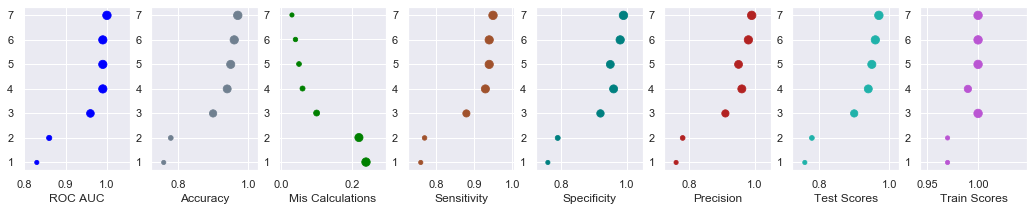

In [5]:
run+=1
evolution_creation_model_simple(str(run))


Number of authors:
Most recent 2000 evolution posts are from 1163 authors.
Most recent 1714 creation posts are from 243 authors.


Number of common authors:
Common authors : 4 authors



Top words used under r/evolution


,1,2,3,4,5,6,7
evolution,541.0,872.0,872.0,2024.0,2024.0,2024.0,2033.0
evolutionary,165.0,322.0,322.0,322.0,322.0,322.0,323.0
humans,146.0,329.0,329.0,329.0,329.0,329.0,329.0
human,140.0,270.0,270.0,270.0,270.0,270.0,270.0
species,116.0,295.0,295.0,295.0,295.0,295.0,295.0
life,79.0,207.0,207.0,207.0,207.0,207.0,207.0
evolve,77.0,173.0,173.0,173.0,173.0,173.0,173.0
like,68.0,330.0,331.0,331.0,331.0,331.0,331.0
would,60.0,328.0,328.0,328.0,328.0,328.0,328.0
evolved,57.0,162.0,162.0,162.0,162.0,162.0,162.0



Top words used under r/Creation


,1,2,3,4,5,6,7
evolution,220.0,485.0,485.0,485.0,485.0,485.0,485.0
creation,114.0,377.0,377.0,1214.0,1214.0,1214.0,1235.0
evidence,85.0,269.0,269.0,269.0,269.0,269.0,269.0
science,84.0,243.0,243.0,243.0,243.0,243.0,283.0
earth,79.0,230.0,230.0,231.0,231.0,231.0,337.0
years,67.0,241.0,241.0,241.0,241.0,241.0,244.0
god,45.0,215.0,215.0,218.0,218.0,218.0,233.0
would,45.0,374.0,374.0,374.0,374.0,374.0,374.0



Top words used under r/evolution and r/Creation combined


,1,2,3,4,5,6,7
evolution,761.0,1357.0,1357.0,2509.0,2509.0,2509.0,2518.0
evolutionary,203.0,495.0,495.0,495.0,495.0,495.0,506.0
human,185.0,441.0,441.0,441.0,441.0,441.0,441.0
humans,178.0,448.0,448.0,448.0,448.0,448.0,448.0
life,127.0,417.0,417.0,417.0,417.0,417.0,418.0
creation,121.0,391.0,391.0,1229.0,1229.0,1229.0,1250.0
years,120.0,395.0,395.0,395.0,395.0,395.0,398.0
like,107.0,680.0,681.0,681.0,681.0,681.0,681.0
would,105.0,702.0,702.0,702.0,702.0,702.0,702.0



Metrics for 3714 posts


,Feature Set,Train Scores,Test Scores,Accuracy,Mis Calculations,Sensitivity,Specificity,Precision,ROC AUC,Fit Type
0,1,0.96,0.78,0.78,0.22,0.73,0.82,0.78,0.85,Overfit
1,2,0.97,0.80,0.80,0.20,0.79,0.81,0.78,0.87,Overfit
2,3,0.99,0.91,0.91,0.09,0.86,0.96,0.95,0.95,Overfit
3,4,0.99,0.95,0.95,0.05,0.93,0.97,0.96,0.99,Overfit
4,5,0.99,0.94,0.94,0.06,0.93,0.95,0.94,0.99,Overfit
5,6,1.00,0.96,0.96,0.04,0.93,0.99,0.98,0.99,Overfit
6,7,1.00,0.96,0.96,0.04,0.94,0.98,0.97,0.99,Overfit


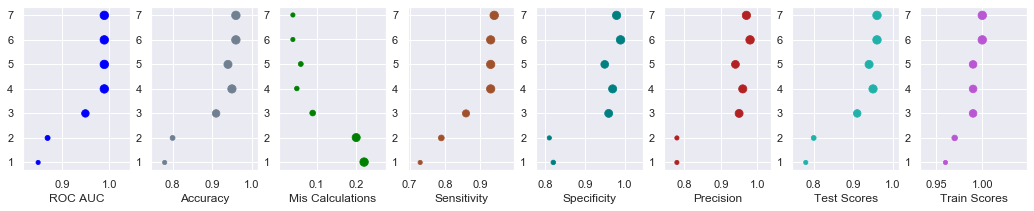

In [6]:
run+=1
evolution_creation_model_simple(str(run))